In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.applications as app
import keras.layers as kl
import seaborn as sns
import matplotlib.patheffects as PathEffects
import cv2
import os
import imgaug.augmenters as iaa

from tqdm import tqdm as tqdm
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.optimizers import Adagrad, RMSprop
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
epoch = 5
m     = 1.09

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train_),(x_test, y_test_) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

few_shot_number = np.sum(y_train_ == 8)
few_shot = random.choice(x_train[y_train_ == 8])
few_shot = np.array(np.sum(y_train_ == 8)*[few_shot])

In [5]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 3)),
    iaa.Fliplr(0.5),
    iaa.OneOf([iaa.PiecewiseAffine(scale=(0.02, 0.05)), 
               iaa.Affine(shear=(-12, 12))]),
    iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10))),
    iaa.Sometimes(0.8, iaa.Affine(scale={"x": (0.7, 1.2), "y": (0.7, 1.2)})),
    iaa.Sometimes(0.7, iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}))
])

In [6]:
few_shot_aug = seq.augment_images(few_shot)

In [7]:
x_train  = x_train[y_train_ != 8]
y_train_ = y_train_[y_train_ != 8]

x_train = np.concatenate([x_train, few_shot_aug])
y_train_ = np.concatenate([y_train_, np.array(few_shot_number*[8])])

x_movie = x_train[:500]
y_movie = y_train_[:500]

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train2 = np.zeros((len(x_train), 10))
for j, i in enumerate(y_train_):
    y_train2[j, i] = 1
    
y_test2 = np.zeros((len(x_test), 10))
for j, i in enumerate(y_test_):
    y_test2[j, i] = 1

In [8]:
def triplet_generation(x, y, sample = 500):
    data = [[] for _ in range(10)]
    triplets = []
    for pair in zip(x, y):
        data[pair[1]].append(pair[0])
    for number in range(10):
        for _ in range(sample):
            negative = list(range(10))
            negative.pop(number)
            negative = random.choice(negative)
            triplet = ([random.choice(data[number]), 
                       random.choice(data[number]), 
                       random.choice(data[negative])], 
                       number)
            triplets.append(triplet)
    return np.array(triplets)

In [9]:
boucles = [0, 2, 6, 9, 8]
def triplet_loss(y_true, y_pred, m = 1.09):
    length = int((y_pred[0].shape[-1]))
    
    y_anchor    = np.array(y_true[:, 0])
    y_negative  = np.array(y_true[:, 1])
    opposite_class  = np.bitwise_xor(np.isin(y_anchor, boucles), np.isin(y_negative, boucles))
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec * (1 - 0.5*opposite_class)), axis = 1)

    loss = bad - good + m
    return K.maximum(loss, 0.)

In [10]:
boucles = [0, 2, 6, 9, 8]
def triplet_loss_base(y_true, y_pred, m = 1.09):
    length = int((y_pred[0].shape[-1]))
    
    y_anchor    = np.array(y_true[:, 0])
    y_negative  = np.array(y_true[:, 1])
    
    anchor_vec   = y_pred[:, :int(length/3)]
    positive_vec = y_pred[:, int(length/3):int(length/1.5)]
    negative_vec = y_pred[:, int(length/1.5):length]
    
    bad  = K.sum(K.square(anchor_vec - positive_vec), axis = 1)
    good = K.sum(K.square(anchor_vec - negative_vec), axis = 1)

    loss = bad - good + m
    return K.maximum(loss, 0.)

In [11]:
def one_hot(y):
    encodded = np.zeros((len(y), 10))
    for i in range(len(encodded)):
        encodded[i, y[i]] = 1
    return encodded

In [12]:
def get_triplets(model, x_train, y_train, biaised = False):
    embeddings = model.predict(x_train)
    classes = np.argmax(y_train, axis = 1)
    triplet = []
    
    if biaised:
        distances = distance_matrix_biased(embeddings, classes)
    else:
        distances = distance_matrix(embeddings)
        
    classes_neg = np.ones(y_train.shape) - y_train
    mask_neg = np.dot(y_train, np.transpose(classes_neg))
    distances = distances * mask_neg
    distances[distances == 0] = np.max(distances) + 1
    for i, anchor in enumerate(x_train):
        validate = np.where(classes == classes[i])[0]
        for j in validate:
            k = np.random.choice((-distances[i]).argsort()[-15:][::-1])
            triplet.append((i, j, k))
    return triplet

In [13]:
def distance_matrix(embeddings, squared=False):
    dot_product = np.dot(embeddings, np.transpose(embeddings))
    square_norm = np.diagonal(dot_product)
    distances = np.tile(square_norm, (square_norm.shape[0], 1)) - 2.0 * dot_product + np.transpose(np.tile(square_norm, (square_norm.shape[0], 1)))
    distances[distances < 0.0] = 0.0
    
    if not squared:
        mask = distances == 0.0
        distances = distances + mask * 1e-16
        distances = np.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances

In [15]:
def visual(model):
    x = model.predict(x_test.reshape(-1,28,28,1))
    palette = np.array(sns.color_palette("hls", 10))
    fig = plt.figure(figsize=(12, 11))
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                      c=palette[np.array(np.isin(y_test_, boucles)).astype(np.int)]);
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)
    axi = fig.add_subplot(2, 2, 2, projection='3d')
    axi.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                      c=palette[np.array(y_test_).astype(np.int)]);
    axi.set_xlim(-1.5, 1.5)
    axi.set_ylim(-1.5, 1.5)
    axi.set_zlim(-1.5, 1.5)
    fig.savefig('')

In [16]:
anchor_input   = kl.Input((28, 28, 1), name = 'anchor_input')
positive_input = kl.Input((28, 28, 1), name = 'positive_input')
negative_input = kl.Input((28, 28, 1), name = 'negative_input')

In [17]:
def base_model():
    model = Sequential()
    model.add(kl.Conv2D(32, 2, input_shape=(28, 28,1), padding='valid'))
    model.add(kl.PReLU())
    model.add(kl.MaxPooling2D())
    model.add(kl.Conv2D(64, 2, padding='valid'))
    model.add(kl.PReLU())
    model.add(kl.MaxPooling2D())
    model.add(kl.Flatten())
    model.add(kl.Dense(256))
    model.add(kl.PReLU())
    model.add(kl.Dropout(0.5))
    model.add(kl.Dense(3, activity_regularizer = l2(0.0001)))
    
    return model

In [18]:
shared_network = base_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
anchor   = shared_network(anchor_input)
positive = shared_network(positive_input)
negative = shared_network(negative_input)

merged = kl.concatenate([anchor, positive, negative], axis = 1)

model  = Model(inputs = [anchor_input, positive_input, negative_input], outputs = merged)
loaded_model = Model(inputs = anchor_input, outputs = anchor)

In [20]:
opt = Adagrad()
opt2 = RMSprop(lr = 0.0001)

In [21]:
model.compile(optimizer = opt, loss = triplet_loss_base)

In [22]:
y_train3 = [int(i in boucles) for i in y_train_]
y_test3  = [int(i in boucles) for i in y_test_]

y_train3 = one_hot(y_train3)[:, :2]
y_test3  = one_hot(y_test3)[:, :2]

In [ ]:
frame = 0
for _ in range(1):
    c = list(zip(x_train, y_train3))
    random.shuffle(c)
    x_train, y_train3 = zip(*c)
    x_train   = np.array(x_train)
    y_train3  = np.array(y_train3)
    for batch in tqdm(range(0, int(len(x_train)/2), 32)):
        loaded_model.set_weights(model.get_weights())
        anchor    = []
        positive  = []
        negative  = []
        y         = []
        data_x    = x_train[batch: batch+32]
        data_y    = y_train3[batch: batch+32]
        one_hot_y = data_y
        triplets  = get_triplets(loaded_model, data_x, one_hot_y)
        for (i, j, k) in triplets:
            anchor.append(data_x[i])
            positive.append(data_x[j])
            negative.append(data_x[k])
            y.append([data_y[i], data_y[k]])
        y = np.array(y)
        model.fit([anchor, positive, negative], y, batch_size = 32, verbose = 0)
        if not frame % 70:
            x = model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize=(12, 11))
            ax = fig.add_subplot(2, 2, 1, projection='3d')
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(np.isin(y_movie[:500], boucles)).astype(np.int)]);
            ax.set_xlim(-1.5, 1.5)
            ax.set_ylim(-1.5, 1.5)
            ax.set_zlim(-1.5, 1.5)
            axi = fig.add_subplot(2, 2, 2, projection='3d')
            axi.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            axi.set_xlim(-1.5, 1.5)
            axi.set_ylim(-1.5, 1.5)
            axi.set_zlim(-1.5, 1.5)
            fig.savefig('./movie/first_sep{}.png'.format(frame//70))
            plt.close(fig)
        frame += 1
    model.save_weights('./few_shot_first.h5')

In [24]:
model.save_weights('./First_part.h5')

In [28]:
anchor_input = kl.Input((28, 28, 1), name = 'anchor_input')
anchor       = shared_network(anchor_input)
new_model    = Model(inputs = anchor_input, outputs = anchor)

In [29]:
new_model.load_weights('./First_part.h5')

In [38]:
test

array([[-0.7162855 ,  1.0423422 ,  0.10645751],
       [-0.2316738 ,  0.40283334,  0.06345081],
       [-0.39066225,  0.5873119 ,  0.16181773],
       [-0.4712087 ,  1.0562831 ,  0.02478101],
       [ 0.6831362 , -0.9069191 ,  0.01065883],
       [-0.4810009 ,  0.77262133,  0.16017792],
       [ 0.06779427, -0.15487805,  0.08419564],
       [ 0.3646236 , -0.61129993, -0.05776482],
       [ 0.6651578 , -0.8684971 , -0.05480908],
       [-0.4124531 ,  0.7804717 ,  0.05904972]], dtype=float32)

In [27]:
model.save_weights("./First_part.h5")

In [39]:
anchor   = shared_network(anchor_input)
positive = shared_network(positive_input)
negative = shared_network(negative_input)

merged = kl.concatenate([anchor, positive, negative], axis = 1)

model  = Model(inputs = [anchor_input, positive_input, negative_input], outputs = merged)

In [40]:
model.load_weights("./First_part.h5")
model.compile(optimizer = opt2, loss = triplet_loss)

In [41]:
frame = 0
for _ in tqdm(range(epoch)):
    c = list(zip(x_train, y_train_))
    random.shuffle(c)
    x_train, y_train_ = zip(*c)
    x_train   = np.array(x_train)
    y_train_  = np.array(y_train_)
    for batch in range(0, len(x_train), 32):
        loaded_model.set_weights(model.get_weights())
        anchor    = []
        positive  = []
        negative  = []
        y         = []
        data_x    = x_train[batch: batch+32]
        data_y    = y_train_[batch: batch+32]
        one_hot_y = one_hot(data_y)
        triplets  = get_triplets(loaded_model, data_x, one_hot_y)
        for (i, j, k) in triplets:
            anchor.append(data_x[i])
            positive.append(data_x[j])
            negative.append(data_x[k])
            y.append([data_y[i], data_y[k]])
        y = np.array(y)
        model.fit([anchor, positive, negative], y, batch_size = 32, verbose = 0)
        if not frame % 70:
            x = model.predict(3*[x_movie[:500].reshape(-1,28,28,1)])[:, :3]
            palette = np.array(sns.color_palette("hls", 10))
            fig = plt.figure(figsize=(12, 11))
            ax = fig.add_subplot(2, 2, 1, projection='3d')
            ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(np.isin(y_movie[:500], boucles)).astype(np.int)]);
            ax.set_xlim(-1.5, 1.5)
            ax.set_ylim(-1.5, 1.5)
            ax.set_zlim(-1.5, 1.5)
            axi = fig.add_subplot(2, 2, 2, projection='3d')
            axi.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                                c=palette[np.array(y_movie[:500]).astype(np.int)]);
            axi.set_xlim(-1.5, 1.5)
            axi.set_ylim(-1.5, 1.5)
            axi.set_zlim(-1.5, 1.5)
            fig.savefig('./movie/{}.png'.format(frame//70))
            plt.close(fig)
        frame += 1
    model.save_weights('./few_shot.h5')


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
model.save_weights('./few_shot.h5')

In [43]:
anchor   = shared_network(anchor_input)
new_model    = Model(inputs = anchor_input, outputs = anchor)
new_model.load_weights('./few_shot.h5')

In [44]:
test = new_model.predict(x_train[:10])

In [45]:
test

array([[-0.00985775, -0.08915132,  0.00503622],
       [ 0.02151229, -0.09079147, -0.02535046],
       [-0.03342067, -0.08161645,  0.01096588],
       [ 0.00173213, -0.07439836, -0.01202941],
       [-0.0235634 , -0.06412663, -0.02016755],
       [-0.0146192 , -0.06215233, -0.01604239],
       [ 0.0137947 , -0.06580283, -0.00486049],
       [-0.00230564, -0.09928572, -0.01254341],
       [-0.00921576, -0.0742741 ,  0.04173734],
       [ 0.03505268, -0.06881213,  0.01144783]], dtype=float32)

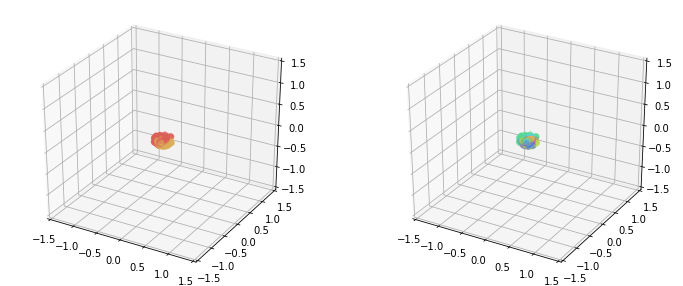

In [46]:
visual(new_model)

In [35]:
x = new_model(anchor_input)
x = kl.Dense(2, activation = 'softmax')(x)

In [36]:
model_classifier = Model(inputs = anchor_input, output = x)

C:\Users\Utilisateur\.conda\envs\keelab\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("an..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [37]:
for l in model_classifier.layers[:-1]:
    l.trainable = False

In [38]:
opt3 = RMSprop()

In [39]:
model_classifier.compile(loss = "categorical_crossentropy", 
              optimizer = opt3,
              metrics   = ["accuracy"])

In [40]:
y_train3 = [int(i in boucles) for i in y_train_]
y_test3  = [int(i in boucles) for i in y_test_]

In [41]:
y_train3 = [int(i in boucles) for i in y_train_]
y_test3  = [int(i in boucles) for i in y_test_]

y_train3 = one_hot(y_train3)[:, :2]
y_test3  = one_hot(y_test3)[:, :2]

In [42]:
hist = model_classifier.fit(x_train,
          y               = y_train3,
          validation_data = (x_test, y_test3), 
          batch_size      = 128, 
          epochs          = 10
          ) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 7:18 - loss: 1.1202 - acc: 0.414 - ETA: 4:26 - loss: 1.1022 - acc: 0.398 - ETA: 3:50 - loss: 1.1424 - acc: 0.377 - ETA: 3:32 - loss: 1.1407 - acc: 0.380 - ETA: 3:11 - loss: 1.1544 - acc: 0.364 - ETA: 3:07 - loss: 1.1654 - acc: 0.355 - ETA: 3:00 - loss: 1.1579 - acc: 0.351 - ETA: 2:50 - loss: 1.1678 - acc: 0.345 - ETA: 2:42 - loss: 1.1550 - acc: 0.352 - ETA: 2:36 - loss: 1.1514 - acc: 0.350 - ETA: 2:31 - loss: 1.1690 - acc: 0.345 - ETA: 2:28 - loss: 1.1641 - acc: 0.343 - ETA: 2:26 - loss: 1.1623 - acc: 0.346 - ETA: 2:21 - loss: 1.1589 - acc: 0.346 - ETA: 2:17 - loss: 1.1523 - acc: 0.347 - ETA: 2:13 - loss: 1.1526 - acc: 0.349 - ETA: 2:11 - loss: 1.1508 - acc: 0.351 - ETA: 2:09 - loss: 1.1518 - acc: 0.351 - ETA: 2:06 - loss: 1.1491 - acc: 0.352 - ETA: 2:04 - loss: 1.1503 - acc: 0.350 - ETA: 2:01 - loss: 1.1492 - acc: 0.348 - ETA: 1:59 - loss: 1.1428 - acc: 0.348 - ETA: 1:57 - 

In [43]:
y_pred = model_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

In [44]:
matrix = confusion_matrix(y_test_,
                          y_pred,
                          labels = [i for i in range(10)])

In [45]:
matrix[:, :2]

array([[   1,  979],
       [1108,   27],
       [ 296,  736],
       [ 952,   58],
       [ 536,  446],
       [ 213,  679],
       [   1,  957],
       [1026,    2],
       [ 330,  644],
       [ 975,   34]], dtype=int64)